In [1]:
from __future__ import unicode_literals

import os
from os.path import join as pjoin
import pandas as pd
from pandas import DataFrame, Series
from boltons.fileutils import mkdir_p

DATA_PATH = pjoin(os.getenv('CAMELID_HOME'), 'cas2cid', 'data')
MD_RESULTS = pjoin(DATA_PATH, 'CASRN-CID MD analysis 2014-04-20.csv')
CID_INCHIKEY = pjoin(DATA_PATH, 'CID-InChIKey 2014-04-20.csv')
RESULTS_PATH = pjoin(os.getenv('CAMELID_HOME'), 'cas2cid', 'results')
mkdir_p(RESULTS_PATH)

# CML CASRN - PubChem CID alignment process (homework)

## Goal

Take the output from PubChem ID Exchange conversion of all CASRNs in the CML into CIDs, and determine whether each association is OK to import into the CML or requires further resolution.

Secondary goal: reproduce, as an automatable process in Python/pandas, Michel's spreadsheet-based processing that is already done.

## Data source

A copy of [the spreadsheet](https://drive.google.com/open?id=1F60y2Fqchb1hy0Iu-RzUVMwaAxHnm982D_ZYBAVwiRE) in which Michel did the processing. I will start with the output from the ID Exchange, a list of CASRN - CID associations and the InChIKey corresponding to each CID. Since I don't have the actual output from 2014-04-20, I manually extracted CASRN-CID associations (first two columns of the "CASRN->CID" worksheet) and CID-InChIKey mappings (first two columns of "CID->InChIKey" worksheet) from that spreadsheet. I will merge these as needed.


## Assumptions about the dataset

I assume that (CASRN, CID) associations are not repeated, and that each unique CID is only associated with one InChIKey. These both are confirmed below.


# Step 1. Find mappings that are already 1:1

We will accept as valid all 1:1 CID:CASRN mappings output by PubChem.

First load the data and make sure it's sane.

In [2]:
mdata = pd.read_csv(MD_RESULTS)
ids = mdata.iloc[:,[0,1]]
q = len(ids)
print(q, "identifier correspondences")

# Check first assumption
assert len(ids.drop_duplicates()) == len(ids)

inchikeys = pd.read_csv(CID_INCHIKEY)
inchikeys = inchikeys.iloc[:,[0,1]]
print(len(inchikeys), "CID-InChIKey mappings")

# Check second assumption
assert len(inchikeys.drop_duplicates()) == len(inchikeys.drop_duplicates(subset='CID'))

ids = ids.merge(inchikeys, on='CID', how='inner', sort=True).drop_duplicates()
print(len(ids), "identifier correspondences with InChIKeys")
# Can't have any extra or missing rows.
assert len(ids) == q
# Can't have any missing values, or something is wrong.
assert all(ids.notnull())

# Make sure it is sorted by CASRN then by CID.
ids.sort_values(by=['CASRN', 'CID'], inplace=True)
ids.reset_index(drop=True, inplace=True)

ids.head(10)

25357 identifier correspondences
25357 CID-InChIKey mappings
25357 identifier correspondences with InChIKeys


,CASRN,CID,InChIKey
0,100-00-5,7474,CZGCEKJOLUNIFY-UHFFFAOYSA-N
1,100-01-6,7475,TYMLOMAKGOJONV-UHFFFAOYSA-N
2,100-02-7,980,BTJIUGUIPKRLHP-UHFFFAOYSA-N
3,100-06-1,7476,NTPLXRHDUXRPNE-UHFFFAOYSA-N
4,100-07-2,7477,MXMOTZIXVICDSD-UHFFFAOYSA-N
5,100-09-4,7478,ZEYHEAKUIGZSGI-UHFFFAOYSA-N
6,100-10-7,7479,BGNGWHSBYQYVRX-UHFFFAOYSA-N
7,100-11-8,66011,VOLRSQPSJGXRNJ-UHFFFAOYSA-N
8,100-12-9,7480,RESTWAHJFMZUIZ-UHFFFAOYSA-N
9,100-14-1,7482,KGCNHWXDPDPSBV-UHFFFAOYSA-N


## Calculate degrees of mapping for each ID

Determine which IDs are mapped 1:1, ..., n:m. Not sure what the correct terminology is, but anyway, we need to compute two values for each row:

- For every CASRN, how many CIDs have been associated with that CASRN? I'll call this `n_cid_casrn`.
- For every CID, how many CASRNs have been associated with that CID? I'll call this `n_casrn_cid`.

I compute these values for each *unique* CASRN or CID, and then add the appropriate corresponding value to every (CASRN, CID) row in the DataFrame.

In [3]:
# Compute number of CIDs for each unique CASRN.
n_cid_casrn = ids[['CASRN', 'CID']].groupby('CASRN').count()
ids['n_cid_casrn'] = ids['CASRN'].apply(lambda x: n_cid_casrn.loc[x, 'CID'])

# Compute number of CASRNs for each unique CID.
n_casrn_cid = ids[['CASRN', 'CID']].groupby('CID').count()
ids['n_casrn_cid'] = ids['CID'].apply(lambda x: n_casrn_cid.loc[x, 'CASRN'])

ids.head()

,CASRN,CID,InChIKey,n_cid_casrn,n_casrn_cid
0,100-00-5,7474,CZGCEKJOLUNIFY-UHFFFAOYSA-N,1,1
1,100-01-6,7475,TYMLOMAKGOJONV-UHFFFAOYSA-N,1,1
2,100-02-7,980,BTJIUGUIPKRLHP-UHFFFAOYSA-N,1,1
3,100-06-1,7476,NTPLXRHDUXRPNE-UHFFFAOYSA-N,1,1
4,100-07-2,7477,MXMOTZIXVICDSD-UHFFFAOYSA-N,1,1


### Plot

Histograms of CAS and CID degrees-of-mapping show that this dataset is predominantly 1:1 mapping.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c93cea128>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9c93c4b3c8>]], dtype=object)

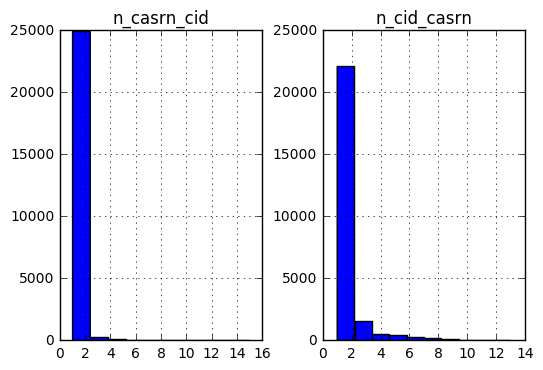

In [4]:
%matplotlib inline
ids.hist(column=['n_cid_casrn', 'n_casrn_cid'])

## Separate the 1:1 mappings

We now have the first set of 1:1 correspondences.

In [5]:
mapped_11 = ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn == 1)]
print(len(mapped_11), '1:1 CASRN-CID mappings')
mapped_11.head()

18729 1:1 CASRN-CID mappings


,CASRN,CID,InChIKey,n_cid_casrn,n_casrn_cid
0,100-00-5,7474,CZGCEKJOLUNIFY-UHFFFAOYSA-N,1,1
1,100-01-6,7475,TYMLOMAKGOJONV-UHFFFAOYSA-N,1,1
2,100-02-7,980,BTJIUGUIPKRLHP-UHFFFAOYSA-N,1,1
3,100-06-1,7476,NTPLXRHDUXRPNE-UHFFFAOYSA-N,1,1
4,100-07-2,7477,MXMOTZIXVICDSD-UHFFFAOYSA-N,1,1


### Plot degrees of remaining n:m correspondences

The rest of the `ids` DataFrame contains associations for which there is either more than one CID, more than one CASRN, or both. Here are histograms of CAS and CID degrees-of-mapping once we have removed 1:1 mappings.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c94f125f8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f9c9399f2b0>]], dtype=object)

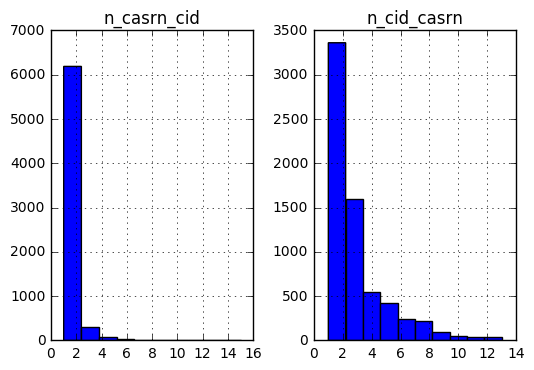

In [6]:
# %matplotlib inline
ids[(ids.n_casrn_cid > 1) | (ids.n_cid_casrn > 1)].hist(column=['n_cid_casrn', 'n_casrn_cid'])

# Step 2. Find 1:n CASRN:CID mappings that are structually feasible

### Goal

Accept CASRN-CID mappings where multiple CIDs were associated to a single CASRN (i.e., none of those CIDs were associated with other CASRNs), *and* all of those CIDs represent compounds having the same structural skeleton (excluding steroisomerism, tautomerism, ionization, etc.).

Michel's notes: "if this CID is associated with only one CASRN AND any other CIDs associated with this CASRN have the same InChIKey, then import."

### Selection logic

In Michel's spreadsheet the following test to determines whether to accept a correspondence:

1. the number of CASRNs associated with the CID is 1; AND
2. the number of CIDS associated with the CASRN == the number of occurrences of the structural skeleton associated with the CASRN throughout the whole dataset.

I will use a different logical operation for the second part of the test than Michel did, just because it makes more intuitive sense to me and is a simpler operation in pandas:

1. the number of CASRNs associated with the CID is 1 (below, `n_casrn_cid == 1`); AND
2. the number of unique structural skeletons associated with the CASRN throughout the whole dataset is 1 (below, `n_key_casrn` == 1).

**I will try both and check whether they're equivalent.**

In [7]:
# Needed for both approaches: isolate the structural base layer from each InChIKey.
ids['key'] = ids['InChIKey'].apply(lambda x: str(x)[:14])

## Step 2, Spreadsheet approach

This is what is done in the spreadsheet... I think!

- Compute the number of CASRNs associated with the CID is 1 (`n_casrn_cid == 1`, already done)
- Compute the number of CIDS associated with the CASRN (`n_cid_casrn`, already done)
- Compute the number of times the CASRN and the base structure key occur together (i.e., "instances of CAS-InChIKey", which I will call `f_key_casrn`)
    - **This must be computed using the whole dataset! (Not just for the set of 1:n associations.) Otherwise the results are bogus.**
- Test condition: An association is OK if `n_casrn_cid == 1` AND `n_cid_casrn == f_key_casrn`.

In [8]:
# This is a hack to compute "instances of CAS-InChIKey".
ids['caskey'] = ids.CASRN.astype(str) + ids.key.astype(str)
counts = ids['caskey'].reset_index().groupby('caskey').count()
ids['f_key_casrn'] = ids['caskey'].apply(lambda x: counts['index'][x])
ids.drop('caskey', axis=1).sort_values(by='CASRN').head()

,CASRN,CID,InChIKey,n_cid_casrn,n_casrn_cid,key,f_key_casrn
0,100-00-5,7474,CZGCEKJOLUNIFY-UHFFFAOYSA-N,1,1,CZGCEKJOLUNIFY,1
1,100-01-6,7475,TYMLOMAKGOJONV-UHFFFAOYSA-N,1,1,TYMLOMAKGOJONV,1
2,100-02-7,980,BTJIUGUIPKRLHP-UHFFFAOYSA-N,1,1,BTJIUGUIPKRLHP,1
3,100-06-1,7476,NTPLXRHDUXRPNE-UHFFFAOYSA-N,1,1,NTPLXRHDUXRPNE,1
4,100-07-2,7477,MXMOTZIXVICDSD-UHFFFAOYSA-N,1,1,MXMOTZIXVICDSD,1


## Apply the test condition

In [9]:
alt1n = ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1)].copy()
print(len(alt1n), 'CASRN-CID associations with multiple CIDs')

alt_mapped_1n = alt1n[alt1n['n_cid_casrn'] == alt1n['f_key_casrn']]  #.copy().drop('key', axis=1)
alt_unmapped_1n = alt1n[alt1n['n_cid_casrn'] != alt1n['f_key_casrn']]  #.copy().drop('key', axis=1)

print('Compare-counts method:', len(alt_mapped_1n), 'bulk import')
print('Compare-counts method:', len(alt_unmapped_1n), 'resolve later')

4528 CASRN-CID associations with multiple CIDs
Compare-counts method: 3364 bulk import
Compare-counts method: 1164 resolve later


## Step 2, Groupby/count-unique method

### Outline of the code below

- Create a new DataFrame that contains all identifier correspondences where one CASRN maps to multiple CID.
- Split off the first 14 characters of each InChIKey (i.e. a hash of the connectivity layer of the InChI) to use as a proxy identifier for structural skeletons.
- Use the pandas `groupby` and `nunique` methods to determine how many unique base structures are associated with each CASRN (via the CIDs).
- Apply the selection logic to determine which IDs can be mapped acceptably, and which cannot.

We'll see if we get the same answer as the spreadsheet method.

## Compute degree of structural mapping for each set of 1:n CASRN:CIDs

For every CASRN, how many unique structural skeletons have been associated with that CASRN in the dataset? I'll call this `n_key_casrn`. 

**This must be computed using the whole dataset! (Not just for the set of 1:n associations.) Otherwise the results are bogus.**

In [10]:
n_key_casrn = ids[['CASRN', 'key']].groupby('CASRN')['key'].nunique()
ids['n_key_casrn'] = ids['CASRN'].apply(lambda x: n_key_casrn[x])

## Apply the test condition to find acceptable 1:n mappings

In [11]:
df1n = ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn > 1)].copy()
print(len(df1n), 'CASRN-CID associations with multiple CIDs')
mapped_1n = df1n[df1n['n_key_casrn'] == 1]  #.copy().drop('key', axis=1)
print(len(mapped_1n), '1:n CASRN:CID associations all sharing the same base structure')
mapped_1n.head()

4528 CASRN-CID associations with multiple CIDs
3364 1:n CASRN:CID associations all sharing the same base structure


,CASRN,CID,InChIKey,n_cid_casrn,n_casrn_cid,key,caskey,f_key_casrn,n_key_casrn
44,100-59-4,7513,IWCVDCOJSPWGRW-UHFFFAOYSA-M,2,1,IWCVDCOJSPWGRW,100-59-4IWCVDCOJSPWGRW,2,1
45,100-59-4,6093176,IWCVDCOJSPWGRW-UHFFFAOYSA-M,2,1,IWCVDCOJSPWGRW,100-59-4IWCVDCOJSPWGRW,2,1
73,10016-20-3,24796,HFHDHCJBZVLPGP-JSPYPFAESA-N,4,1,HFHDHCJBZVLPGP,10016-20-3HFHDHCJBZVLPGP,4,1
74,10016-20-3,320760,HFHDHCJBZVLPGP-UHFFFAOYSA-N,4,1,HFHDHCJBZVLPGP,10016-20-3HFHDHCJBZVLPGP,4,1
75,10016-20-3,444913,HFHDHCJBZVLPGP-RWMJIURBSA-N,4,1,HFHDHCJBZVLPGP,10016-20-3HFHDHCJBZVLPGP,4,1


In [12]:
unmapped_1n = df1n[df1n['n_key_casrn'] > 1]#  .copy().drop('key', axis=1)
print(len(unmapped_1n), '1:n CASRN:CID associations with more than one base structure')
unmapped_1n.head()

1164 1:n CASRN:CID associations with more than one base structure


,CASRN,CID,InChIKey,n_cid_casrn,n_casrn_cid,key,caskey,f_key_casrn,n_key_casrn
387,10190-68-8,25037,WLDNGJFRVWQASY-UHFFFAOYSA-L,3,1,WLDNGJFRVWQASY,10190-68-8WLDNGJFRVWQASY,1,3
388,10190-68-8,25038,JEPNNQGUMUZZHF-UHFFFAOYSA-N,3,1,JEPNNQGUMUZZHF,10190-68-8JEPNNQGUMUZZHF,1,3
389,10190-68-8,54607659,YWBRZBKWNIBDDD-UHFFFAOYSA-N,3,1,YWBRZBKWNIBDDD,10190-68-8YWBRZBKWNIBDDD,1,3
409,10197-71-4,18764219,IZUPJOYPPLEPGM-UHFFFAOYSA-N,3,1,IZUPJOYPPLEPGM,10197-71-4IZUPJOYPPLEPGM,2,2
410,10197-71-4,23668795,IZUPJOYPPLEPGM-UHFFFAOYSA-M,3,1,IZUPJOYPPLEPGM,10197-71-4IZUPJOYPPLEPGM,2,2


### Plot distribution of number of unique base-structures per CASRN in the 1:n set

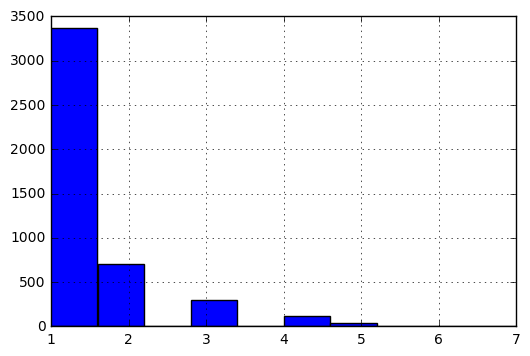

In [13]:
df1n.n_key_casrn.hist()

### Summarize results of this method for 1:n mappings

In [14]:
print('Groupby/count-unique method:', len(mapped_1n), 'bulk import')
print('Groupby/count-unique method:', len(unmapped_1n), 'resolve later')

Groupby/count-unique method: 3364 bulk import
Groupby/count-unique method: 1164 resolve later


# Step 3 (end of automated workflow)

Combine DataFrames of successfully mapped IDs into one, and unmapped IDs (for further, non-automated resolution) into another.

In [15]:
# Reassign this to include all new columns that we added since...
mapped_11 = ids[(ids.n_casrn_cid == 1) & (ids.n_cid_casrn == 1)]

mapped = pd.concat([mapped_11, mapped_1n], ignore_index=True)
# Set a 'status' column, mainly for comparison to existing results.
mapped['status'] = 'bulk import'

unmapped = pd.concat([unmapped_1n, ids[ids.n_casrn_cid > 1]], ignore_index=True)
unmapped['status'] = 'resolve later'  # Add 'status' column for check.

# Make sure we didn't lose or gain any rows of data throughout this process. 
assert len(mapped) + len(unmapped) == len(ids)

# Create a version for export and manual inspection.
results_ex = pd.concat([mapped, unmapped], ignore_index=True)
results_ex = results_ex[['CASRN', 'CID', 'InChIKey', 'n_cid_casrn', 'n_casrn_cid', 'status']]
results_ex.sort_values(by=['CASRN', 'CID'], inplace=True)
results_ex.reset_index(drop=True, inplace=True)

# Create a version for comparison: eliminate columns not able to compare.
results = results_ex.drop('InChIKey', axis=1)

results.tail()

,CASRN,CID,n_cid_casrn,n_casrn_cid,status
25352,999-40-6,5352162,2,1,bulk import
25353,999-61-1,61249,1,1,bulk import
25354,999-78-0,136786,1,1,bulk import
25355,999-81-5,13836,1,1,bulk import
25356,999-97-3,13838,1,1,bulk import


In [16]:
alt_mapped = pd.concat([alt_mapped_1n, mapped_11], ignore_index=True)
alt_mapped['status'] = 'bulk import'

alt_unmapped = pd.concat([alt_unmapped_1n, ids[ids.n_casrn_cid > 1]], ignore_index=True)
alt_unmapped['status'] = 'resolve later'

assert len(alt_mapped) + len(alt_unmapped) == len(ids)

alt_results = pd.concat([alt_mapped, alt_unmapped], ignore_index=True)
alt_results = alt_results[['CASRN', 'CID', 'n_cid_casrn', 'n_casrn_cid', 'status']]
alt_results.sort_values(by=['CASRN', 'CID'], inplace=True)
alt_results.reset_index(drop=True, inplace=True)

alt_results.tail()

,CASRN,CID,n_cid_casrn,n_casrn_cid,status
25352,999-40-6,5352162,2,1,bulk import
25353,999-61-1,61249,1,1,bulk import
25354,999-78-0,136786,1,1,bulk import
25355,999-81-5,13836,1,1,bulk import
25356,999-97-3,13838,1,1,bulk import


# Step 4: Check results 

The methodology for checking if results are the same is as follows: make an elementwise comparison of two DataFrames that should be the same, e.g., `results_A == results_B`, and then call the `all()` method on the resulting boolean DataFrame. If this evaluates to `True` for all columns in the dataset, then they are all the same.

## Compare different 1:n methods against each other 

In [17]:
print('Groupby/count-unique method TOTAL: {0:>5} bulk import, {1:>5} resolve later'.format(len(mapped), len(unmapped)))
print('Compare-counts method TOTAL: {0:>11} bulk import, {1:>5} resolve later'.format(len(alt_mapped), len(alt_unmapped)))

Groupby/count-unique method TOTAL: 22093 bulk import,  3264 resolve later
Compare-counts method TOTAL:       22093 bulk import,  3264 resolve later


In [18]:
methods_check = results == alt_results
methods_check.all()

CASRN          True
CID            True
n_cid_casrn    True
n_casrn_cid    True
status         True
dtype: bool

## Compare against the spreadsheet

We already have loaded up the whole "CASRN->CID" worksheet, which I previously exported as a standalone CSV file. Now take the important columns to compare elementwise against the DataFrames above.

In [19]:
md = mdata.iloc[:,[0,1,2,3,10]].sort_values(by=['CASRN', 'CID'])
md.reset_index(drop=True, inplace=True)

# Rename the columns
md.columns = ['CASRN', 'CID', 'n_cid_casrn', 'n_casrn_cid', 'status']

# Make sure we have the same total number of correspondences:
assert len(md) == len(ids)

In [20]:
md_check = results == md
md_check.all()

CASRN          True
CID            True
n_cid_casrn    True
n_casrn_cid    True
status         True
dtype: bool

In [21]:
alt_md_check = alt_results == md
alt_md_check.all()

CASRN          True
CID            True
n_cid_casrn    True
n_casrn_cid    True
status         True
dtype: bool

# Analysis

The **pandas "groupby/count-unique" method** produced the same results as **the spreadsheet** and **the "compare-counts" method** (which reproduces the spreadsheet exactly), provided that the data processing operations are done in the right order.

# The final export

In [22]:
results_ex.to_excel(pjoin(RESULTS_PATH, 'CASRN-CID-pandas.xlsx'))